#### Supplement Figure 3

##### Package imports, figure settings, color definitions
<img src="color_pal.png" width="500">

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


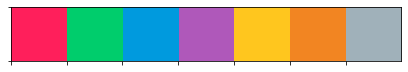

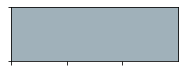

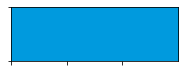

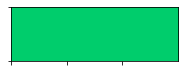

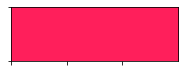

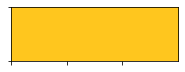

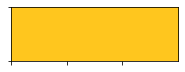

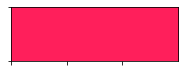

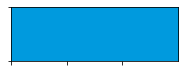

In [1]:
%matplotlib inline
%run settings_load.py

##### minimal model *in silico* tests
code adapted from more general memocell tests "gillespie_test_1" notebook

In [6]:
# compute Gillespie simulation with the framework
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('min_test')
net.structure(t)
sim = me.Simulation(net)
res = sim.simulate('gillespie', variables, initial_values, theta_values, time_values)

In [7]:
# create a data object from simulations for the estimation
num_iter = 10000

res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sim_res_int = np.array(res_list)

In [8]:
data_int = me.Data('data_min_test')
data_int.load(['X_t', 'Y_t'], time_values, sim_res_int, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

In [17]:
# save and (later) load data
# with open('in_silico_files/in_silico_data_cd44_min_paper_test_d4_l3.pickle', 'wb') as file_: # in_silico_estimation
#     pickle.dump(data_int, file_)

data_int = pickle.load(open('in_silico_files/in_silico_data_cd44_min_paper_test_d4_l3.pickle', 'rb'))

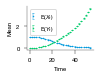

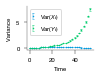

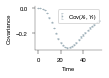

In [18]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'Y_t': {'label': 'E$(Y_t)$', 'color': cactiv},
    'X_t': {'label': 'E$(X_t)$', 'color': cnaive}
}
me.plots.data_mean_plot(data_int, settings=settings)

settings = {
    ('Y_t', 'Y_t'): {'label': 'Var$(Y_t)$', 'color': cactiv},
    ('X_t', 'X_t'): {'label': 'Var$(X_t)$', 'color': cnaive}
}
me.plots.data_variance_plot(data_int, settings=settings)

settings = {
    ('X_t', 'Y_t'): {'label': 'Cov$(X_t, Y_t)$', 'color': grey}
}
me.plots.data_covariance_plot(data_int, settings=settings)

In [19]:
# estimation
def make_net(steps_d, steps_l):
    name = 'min_' + str(steps_d) + '_' + str(steps_l)

    t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd', 'type': 'S -> E', 'reaction_steps': steps_d},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': steps_l}
    ]

    net = me.Network(name)
    net.structure(t)

    return net

nets = [make_net(steps_d, steps_l) for steps_d in range(1, 6) for steps_l in range(1, 6)]
variables = [{'X_t': ('X_t', ), 'Y_t': ('Y_t', )}]*len(nets)
initial_values = [{'X_t': 1.0, 'Y_t': 0.0}]*len(nets)
theta_bounds = [{'d': (0.0, 0.15), 'l': (0.0, 0.15)}]*len(nets)
print(len(nets))


25


In [20]:
est_res_int = me.select_models(nets, variables, initial_values, 
                               theta_bounds, data_int)

In [32]:
# save and (later) load estimation results
# with open('in_silico_files/estimation_in_silico_data_cd44_min_paper_test_d4_l3.pickle', 'wb') as file_: # in_silico_estimation
#     pickle.dump(est_res_int, file_)

est_res_int = pickle.load(open('in_silico_files/estimation_in_silico_data_cd44_min_paper_test_d4_l3.pickle', 'rb'))

In [33]:
net_names = [est.net.net_name for est in est_res_int]
model_probs = me.selection.compute_model_probabilities(est_res_int)
print(net_names.index('min_4_3'))
model_probs[17]

17


1.0

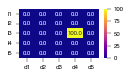

In [41]:
steps_lambda = range(1, 6)
steps_alpha = range(1, 6)
rows = [f'l{i}' for i in steps_lambda]
cols = [f'd{i}' for i in steps_alpha]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'min_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(1.8, 0.9)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')
plt.savefig('paper_figures/min_in_silico_test_probs.pdf', bbox_inches='tight')

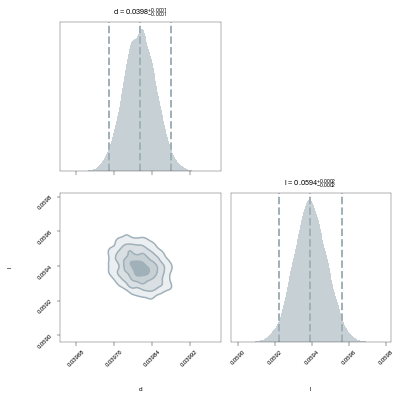

In [43]:
est = est_res_int[17]
me.plots.est_corner_kernel_plot(est)

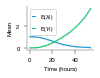

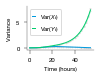

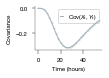

In [42]:
est = est_res_int[17]
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'Y_t': {'label': 'E$(Y_t)$', 'color': cactiv},
    'X_t': {'label': 'E$(X_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', settings=settings, save='paper_figures/min_in_silico_test_mean_min_4_3.pdf')

settings = {
    ('Y_t', 'Y_t'): {'label': 'Var$(Y_t)$', 'color': cactiv},
    ('X_t', 'X_t'): {'label': 'Var$(X_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', settings=settings, save='paper_figures/min_in_silico_test_var_min_4_3.pdf')

settings = {
    ('Y_t', 'X_t'): {'label': 'Cov$(X_t, Y_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', settings=settings, save='paper_figures/min_in_silico_test_cov_min_4_3.pdf')

##### parallel 2 (par2) model *in silico* tests

In [4]:
# compute Gillespie simulation with the framework
t = [
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd4', 'type': 'S -> E', 'reaction_steps': 4},
    {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'd2', 'type': 'S -> E', 'reaction_steps': 2},
    {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 3}
    ]

initial_values = {'X_t': 1, 'Y_t': 0}
theta_values = {'l': 0.06, 'd4': 0.03, 'd2': 0.04}
time_values = np.linspace(0.0, 54.0, num=28, endpoint=True)
variables = {'X_t': ('X_t', ), 'Y_t': ('Y_t', )}

net = me.Network('par2_test')
net.structure(t)

sim = me.Simulation(net)
res = sim.simulate('gillespie', variables, initial_values, theta_values, time_values)

In [5]:
# create a data object from simulations for the estimation
num_iter = 50000

res_list = list()
for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sim_res_int = np.array(res_list)

In [6]:
data_int = me.Data('data_par2_test')
data_int.load(['X_t', 'Y_t'], time_values, sim_res_int, 
              bootstrap_samples=1000, basic_sigma=1/num_iter)

In [9]:
# save and (later) load data
# with open('in_silico_files/in_silico_data_cd44_par2_paper_test_d4_d2_l3.pickle', 'wb') as file_: # in_silico_estimation
#     pickle.dump(data_int, file_)

data_int = pickle.load(open('in_silico_files/in_silico_data_cd44_par2_paper_test_d4_d2_l3.pickle', 'rb'))

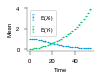

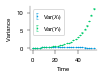

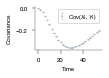

In [10]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'Y_t': {'label': 'E$(Y_t)$', 'color': cactiv},
    'X_t': {'label': 'E$(X_t)$', 'color': cnaive}
}
me.plots.data_mean_plot(data_int, settings=settings)

settings = {
    ('Y_t', 'Y_t'): {'label': 'Var$(Y_t)$', 'color': cactiv},
    ('X_t', 'X_t'): {'label': 'Var$(X_t)$', 'color': cnaive}
}
me.plots.data_variance_plot(data_int, settings=settings)

settings = {
    ('X_t', 'Y_t'): {'label': 'Cov$(X_t, Y_t)$', 'color': grey}
}
me.plots.data_covariance_plot(data_int, settings=settings)

In [11]:
# estimation run in model_select.py script
# load result
est_res_int = pickle.load(open('in_silico_files/estimation_in_silico_data_cd44_par2_paper_test_d4_d2_l3.pickle', 'rb'))

In [14]:
net_names = [est.net.net_name for est in est_res_int]
model_probs = me.selection.compute_model_probabilities(est_res_int)
print(net_names.index('par2_d_4_2_l_3')) # true model
print(net_names.index('par2_d_2_4_l_3')) # symmetric true model

82
42


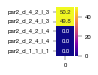

In [26]:
# top 5 models
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

df = pd.DataFrame(model_probs_sorted[:5] * 100.0, index=net_names_sorted[:5])
plt.figure(figsize=(0.4, 0.9)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')
plt.savefig('paper_figures/par2_in_silico_test_probs.pdf', bbox_inches='tight')

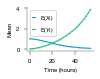

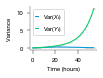

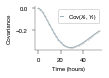

In [30]:
est = est_res_int[82]
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'Y_t': {'label': 'E$(Y_t)$', 'color': cactiv},
    'X_t': {'label': 'E$(X_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', settings=settings, save='paper_figures/par2_in_silico_test_mean_par2_d_4_2_l_3.pdf')

settings = {
    ('Y_t', 'Y_t'): {'label': 'Var$(Y_t)$', 'color': cactiv},
    ('X_t', 'X_t'): {'label': 'Var$(X_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', settings=settings, save='paper_figures/par2_in_silico_test_var_par2_d_4_2_l_3.pdf')

settings = {
    ('Y_t', 'X_t'): {'label': 'Cov$(X_t, Y_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', settings=settings, save='paper_figures/par2_in_silico_test_cov_par2_d_4_2_l_3.pdf')

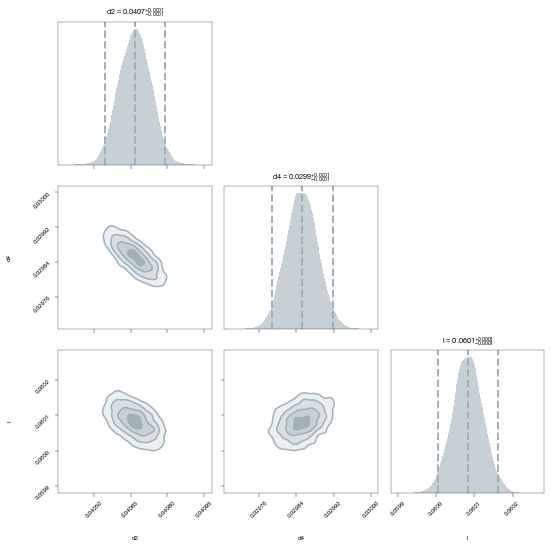

In [31]:
me.plots.est_corner_kernel_plot(est)

##### Parallel 2 single best fit activation and division time distributions
and decomposition of Erlang channels for the activation

In [2]:
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))

In [8]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
log_evids = [est.bay_est_log_evidence for est in res]

sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

data = res[0].data

In [5]:
print(net_names_sorted[:5])
print(net_names.index('par2_d_6_8_l_18'))

['par2_d_6_8_l_18' 'par2_d_6_8_l_14' 'par2_d_6_8_l_10' 'par2_d_6_10_l_14'
 'par2_d_6_10_l_18']
183


In [6]:
# how does it look for best-model only?
samples = 40000
plot_data = True # True or False
time_max = 100.0 # 60.0, 100.0, 200.0
x = np.linspace(0.0, time_max, num=200)

y = waiting_time_distr_samples_act(x, [res[183]], samples, time_max, np.array([1.0]))
print(net_names[183])

[    0.     0. 40000.     0.]
par2_d_6_8_l_18


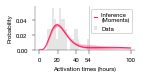

In [9]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

plt.rcParams.update({'figure.figsize': (1.8, 0.8)}) # 1.4, 1.8
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled', label='Data')

plt.fill_between(x, y_997_lower, y_95_lower, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='lightseagreen', lw=2, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='lightseagreen', lw=2, alpha=0.6)
plt.plot(x, y_median, color=cwact, lw=1, zorder=200, label='Inference \n(Moments)')
# plt.plot(x, y_hdi_68_upper, color='lightseagreen', lw=2, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='lightseagreen', lw=2, alpha=0.2)

# plot experimental window
plt.axvline(x=54.0, linewidth=0.5, color=grey)

plt.xticks([0, 20, 40, 54, 100], [0, 20, 40, 54, 100])

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('paper_figures/waiting_times_act_par2_d_6_8_l_18_long100.pdf', bbox_inches='tight') # _long200 # pdf, png

In [10]:
# best model only
samples = 40000
plot_data = False # True or False
time_max = 54.0 # 150.0, 54.0
x = np.linspace(0.0, time_max, num=200)

# NOTE: the data we plot here is only from first divisions! (so its not the complete data, 
# which is inaccessible from the data)

y = waiting_time_distr_samples_div(x, [res[183]], samples, time_max, np.array([1.0]))

[    0.     0. 40000.     0.]


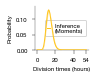

In [11]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

# figure size adapted to fit activation times scale
plt.rcParams.update({'figure.figsize': (0.97, 0.8)}) # 1.4, 0.97
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_count_increase_after_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled', label='Data')
    
plt.fill_between(x, y_997_lower, y_95_lower, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='darkorange', lw=0.5, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='blue', lw=0.5, alpha=0.6)
plt.plot(x, y_median, color=cwdiv, lw=1, zorder=200, label='Inference \n(Moments)')
# plt.plot(x, y_hdi_68_upper, color='darkorange', lw=0.5, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='darkorange', lw=0.5, alpha=0.2)

plt.xticks([0, 20, 40, 54], [0, 20, 40, 54])
plt.ylim(0.0, None)

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('paper_figures/waiting_times_div_par2_d_6_8_l_18.pdf', bbox_inches='tight') # pdf, png

In [12]:
# decompose activation waiting times for the par2 model
# function below adapted from settings_load.py script

def waiting_time_distr_samples_act_composition(x, res, samples, time_max, mprior):
    model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)

    # for checking set a counter
    model_type_counts = np.zeros((4,))

    # set general x values
    # ADAPTED: add three dims in the end
    y = np.zeros((x.shape[0], samples, 3))

    for i in range(samples):
        # get random model according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = res[model_rand]

        # par2 model
        if 'par2_' in est.net.net_name:
            model_type_counts[2] += 1
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # read out steps and rates
            n_d1 = est.net.net_modules[0]['module_steps']
            n_d2 = est.net.net_modules[1]['module_steps']
            d1 = theta[0]
            d2 = theta[1]

            # calculate channel probabilities
            d_total_paths = n_d1 * d1 + n_d2 * d2
            d1_path = (n_d1 * d1)/d_total_paths
            d2_path = (n_d2 * d2)/d_total_paths

            # calculate different gamma pdfs
            d1_scale = 1.0/(n_d1 * d1)
            d2_scale = 1.0/(n_d2 * d2)

            d1_gamma = stats.gamma.pdf(x, a=n_d1, scale=d1_scale)
            d2_gamma = stats.gamma.pdf(x, a=n_d2, scale=d2_scale)

            # compose total gamma over channels
            gamma = d1_path * d1_gamma + d2_path * d2_gamma
        
        # ADAPTED read out
        y[:, i, 0] = gamma
        y[:, i, 1] = d1_path * d1_gamma
        y[:, i, 2] = d2_path * d2_gamma
        
    print(model_type_counts)
    return y

samples = 40000
plot_data = True # True or False
time_max = 100.0 # 60.0, 100.0, 200.0
x = np.linspace(0.0, time_max, num=200)

y = waiting_time_distr_samples_act_composition(x, [res[183]], samples, time_max, np.array([1.0]))
print(net_names[183])

[    0.     0. 40000.     0.]
par2_d_6_8_l_18


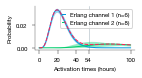

In [23]:
y_95_lower = np.percentile(y[:, :, 0], 2.5, axis=1) # ADAPTED
y_median = np.percentile(y[:, :, 0], 50.0, axis=1) # ADAPTED
y_95_upper = np.percentile(y[:, :, 0], 97.5, axis=1) # ADAPTED

# ADAPTED
y_95_lower_channel1 = np.percentile(y[:, :, 1], 2.5, axis=1)
y_median_channel1 = np.percentile(y[:, :, 1], 50.0, axis=1)
y_95_upper_channel1 = np.percentile(y[:, :, 1], 97.5, axis=1)

# ADAPTED
y_95_lower_channel2 = np.percentile(y[:, :, 2], 2.5, axis=1) 
y_median_channel2 = np.percentile(y[:, :, 2], 50.0, axis=1)
y_95_upper_channel2 = np.percentile(y[:, :, 2], 97.5, axis=1)

plt.rcParams.update({'figure.figsize': (1.8, 0.8)}) # 1.4, 1.8
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if False: # plot_data
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled', label='Data')

# plt.fill_between(x, y_95_lower, y_median, color=grey, alpha=0.4, linewidth=0.0, zorder=100)
# plt.fill_between(x, y_median, y_95_upper, color=grey, alpha=0.4, linewidth=0.0, zorder=100)

plt.fill_between(x, y_95_lower_channel1, y_median_channel1, color=cnaive, alpha=0.4, linewidth=0.0, zorder=150)
plt.fill_between(x, y_median_channel1, y_95_upper_channel1, color=cnaive, alpha=0.4, linewidth=0.0, zorder=150)

plt.fill_between(x, y_95_lower_channel2, y_median_channel2, color=cactiv, alpha=0.4, linewidth=0.0, zorder=150)
plt.fill_between(x, y_median_channel2, y_95_upper_channel2, color=cactiv, alpha=0.4, linewidth=0.0, zorder=150)

plt.plot(x, y_median, color=cwact, linestyle='--', lw=1, zorder=300)
plt.plot(x, y_median_channel1, color=cnaive, lw=1, zorder=200, label='Erlang channel 1 (n=6)')
plt.plot(x, y_median_channel2, color=cactiv, lw=1, zorder=200, label='Erlang channel 2 (n=8)')

# plot experimental window
plt.axvline(x=54.0, linewidth=0.5, color=grey)

plt.xticks([0, 20, 40, 54, 100], [0, 20, 40, 54, 100])

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('paper_figures/waiting_times_act_par2_d_6_8_l_18_long100_comp.pdf', bbox_inches='tight') # _long200 # pdf, png

In [25]:
print(res[183].net.net_modules[0]['module_steps'], # act channel 1
res[183].net.net_modules[1]['module_steps'], # act channel 2
res[183].net.net_modules[2]['module_steps']) # div

6 8 18


##### Best Phase type 3 model fits (par3)

In [2]:
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))

In [4]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
log_evids = [est.bay_est_log_evidence for est in res]

sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

data = res[0].data

In [6]:
print(net_names_sorted[:5])
print(net_names.index('par3_d_6_6_6_l_18'))

['par3_d_6_6_6_l_18' 'par3_d_6_6_6_l_14' 'par3_d_6_6_14_l_18'
 'par3_d_6_6_14_l_14' 'par3_d_8_8_18_l_18']
349


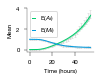

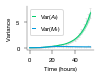

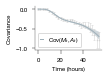

In [9]:
est = res[349]

# repair memocell versions
est.net_time_values_dense = est.data_time_values_dense
est.data.data_mean_exists_only = False

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', settings=settings, save='paper_figures/fit_cd44_mean_par3_d_6_6_6_l_18.pdf')

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', settings=settings, save='paper_figures/fit_cd44_var_par3_d_6_6_6_l_18.pdf')

settings = {
    ('A_t', 'M_t'): {'label': 'Cov$(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', settings=settings, save='paper_figures/fit_cd44_cov_par3_d_6_6_6_l_18.pdf')

##### Probability strip over best models for general inference

In [3]:
res1 = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))
res2 = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))
res3 = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))
res = res1 + res2 + res3
print(len(res1), len(res2), len(res3), len(res))

100 288 588 976


In [4]:
net_names = [est.net.net_name for est in res]
mprior = np.array([0.25] + [0.25/99]*99 + [0.25/288]*288 + [0.25/588]*588)
print(sum(mprior))
model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)
print(len(model_probs))

print(sum(model_probs[0:1]))
print(sum(model_probs[1:100]))
print(sum(model_probs[100:388]))
print(sum(model_probs[388:]))

1.000000000000017
976
4.452090637016675e-205
5.831857248046224e-12
0.557374194770303
0.4426258052238786


In [5]:
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

In [18]:
ntop = 20

# check if all ntop models are phase type
is_ph = True
for name in net_names_sorted[0:ntop]:
    if 'par2_' in name or 'par3_' in name:
        pass
    else:
        is_ph = False
print(is_ph)
print(sum(model_probs_sorted[:ntop]))

True
0.5796308021449896


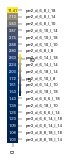

In [16]:

# def process_net_names(net_names):
#     net_names_style = list()
#     for name in net_names:
#         name_style = str(name[4:])
#         name_style = name_style.replace('_', r', ')
#         name_style = name_style.replace('alphaF', r'$n_{\alpha_1}$=')
#         name_style = name_style.replace('alphaS', r'$n_{\alpha_2}$=')
#         name_style = name_style.replace('alphaT', r'$n_{\alpha_3}$=')
#         name_style = name_style.replace('lambda', r'$n_{\lambda}$=')
#         net_names_style.append(name_style)
#     return net_names_style

# def process_net_names_simple(net_names):
#     net_names_style = list()
#     for name in net_names:
#         name_style = str(name[4:])
#         name_style = name_style.replace('_', ' ')
#         name_style = name_style.replace('alphaF1', '1')
#         name_style = name_style.replace('alphaF2', '2  ')
#         name_style = name_style.replace('alphaF4', '4  ')
#         name_style = name_style.replace('alphaF6', '6  ')
#         name_style = name_style.replace('alphaF8', '8  ')
        
#         name_style = name_style.replace('alphaS1', '1')
#         name_style = name_style.replace('alphaS2', '2  ')
#         name_style = name_style.replace('alphaS4', '4  ')
#         name_style = name_style.replace('alphaS6', '6  ')
#         name_style = name_style.replace('alphaS8', '8  ')
        
#         name_style = name_style.replace('alphaT1', '1')
#         name_style = name_style.replace('alphaT2', '2  ')
#         name_style = name_style.replace('alphaT4', '4  ')
#         name_style = name_style.replace('alphaT6', '6  ')
#         name_style = name_style.replace('alphaT8', '8  ')
        
#         name_style = name_style.replace('lambda1', '1')
#         name_style = name_style.replace('lambda2', '2')
#         name_style = name_style.replace('lambda4', '4')
#         name_style = name_style.replace('lambda6', '6')
#         name_style = name_style.replace('lambda8', '8')
#         name_style = 'PH  ' + name_style
#         net_names_style.append(name_style)
#     return net_names_style

plt.rcParams.update({'mathtext.default':  'regular' })
plt.figure(figsize=(0.25,2.5))
df = pd.DataFrame(np.array([model_probs_sorted[:ntop]]).T * 100.0, 
                  index=net_names_sorted[:ntop]) # process_net_names_simple(net_names_sorted[:ntop])
g = sns.heatmap(df, cmap='cividis', annot=True, fmt='.2f', annot_kws={"size":4}, yticklabels=True) # annot=True
ax = plt.gca()
ax.tick_params(right=True, left=False, labelright=True, labelleft=False)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 4)
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/models_probs_strip_all_sigma022.pdf', bbox_inches='tight')

##### Stochastic features for best-fit par2 model (cell count distr.)

In [10]:
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))

In [11]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
data = res[0].data
mprior = np.array([1.0])

print(len(net_names))
print(list(model_probs).index(max(model_probs)))
print(net_names[183])

288
183
par2_d_6_8_l_18


In [12]:
# res = [est]
celltype = 1 # 0 or 1 (active, naive)
time_point = -1 # last time point
sample_n = 1000 # 1000 # posterior samples of cell histograms; typically 1000-10000
sim_n = 500 # 500 # simulation repeats per given model and theta; ideally, inf
count_max = 16
y = hist_cell_counts_samples([res[183]], celltype, time_point, sample_n, count_max, sim_n, mprior)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
print(y.shape)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)

(16, 1000)


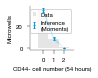

In [19]:
# compute model histogram over all models
# naive_y = y.copy()
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

linelow = 44*y_95_lower/sim_n
line = 44*y_median/sim_n
lineupp = 44*y_95_upper/sim_n
errlow = line-linelow
errupp = lineupp-line

plt.fill_between(range(count_max), linelow, line, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100)
# plt.plot(range(count_max), line, color=cnaive, zorder=200, linewidth=1.0)
plt.fill_between(range(count_max), line, lineupp, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100) #,
#                 label='Models')
cutplot = 3
plt.errorbar(list(range(count_max))[:cutplot], line[:cutplot], yerr=np.array([errlow, errupp])[:, :cutplot],
            color=cnaive, linewidth=1.0, capsize=1.0,
             zorder=100, markersize=2, fmt='.', label='Inference\n(Moments)')

plt.hist(res[0].data.data_counts[:, 1, -1], bins=np.linspace(-0.5, 9.5, num=11), 
         color='black', alpha=0.1, label='Data')
plt.xticks([0, 1, 2])
plt.xlim(None, 3)
plt.ylim(-1.5, None)
plt.xlabel('CD44- cell number (54 hours)')
plt.ylabel('Microwells')
plt.legend()
plt.savefig(f'paper_figures/hist_cd44_naive_bands_par2_d_6_8_l_18.pdf', bbox_inches='tight') # _thin4

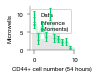

In [9]:
# compute model histogram over all models
# active_y = y.copy()
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

linelow = 44*y_95_lower/sim_n
line = 44*y_median/sim_n
lineupp = 44*y_95_upper/sim_n
errlow = line-linelow
errupp = lineupp-line

plt.fill_between(range(count_max), linelow, line, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100)
# plt.plot(range(count_max), line, color=cactiv, zorder=200, linewidth=1.0)
plt.fill_between(range(count_max), line, lineupp, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100) #,
#                 label='Model')

cutplot = 10
plt.errorbar(list(range(count_max))[:cutplot], line[:cutplot], 
             yerr=np.array([errlow, errupp])[:, :cutplot],
            color=cactiv, linewidth=1.0, capsize=1.0,
             zorder=100, markersize=2, fmt='.', label='Inference\n(Moments)')

plt.hist(res[0].data.data_counts[:, 0, -1], bins=np.linspace(-0.5, 9.5, num=11), 
         color='black', alpha=0.1, label='Data')

plt.xlim(-1, 10)
plt.xlabel('CD44+ cell number (54 hours)')
plt.ylabel('Microwells')
plt.legend()
plt.savefig(f'paper_figures/hist_cd44_active_band_par2_d_6_8_l_18.pdf', bbox_inches='tight') # _thin4

In [17]:
# save naive_y and active_y for replotting
# with open('waiting_times_files/inf_cell_counts_par2_d_6_8_l_18_sigma022_naive_y.pickle', 'wb') as file_: # in_silico_estimation
#     pickle.dump(naive_y, file_)
# with open('waiting_times_files/inf_cell_counts_par2_d_6_8_l_18_sigma022_active_y.pickle', 'wb') as file_: # in_silico_estimation
#     pickle.dump(active_y, file_)

# load from these files to use as 'y' for above plots
# inf_cell_counts_minimal2_par2_par3_sigma022_naive_y
# inf_cell_counts_minimal2_par2_par3_sigma022_active_y
y = pickle.load(open('waiting_times_files/inf_cell_counts_par2_d_6_8_l_18_sigma022_naive_y.pickle', 'rb'))

##### Stochastic features for best-fit par2 model (event analysis)

In [8]:
data = pickle.load(open('waiting_times_files/count_data_cd44_manual_counting_18_01_14_filtered_sigma022.pickle', 'rb'))

In [9]:
data.events_find_all()

In [10]:
print(event_percentage(data.event_all_first_change_from_inital_conditions))
print(event_percentage(data.event_all_first_cell_type_conversion))
print(event_percentage(data.event_all_first_cell_count_increase))
print(event_percentage(data.event_all_first_cell_count_increase_after_cell_type_conversion))
print(event_percentage(data.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion))
print(event_percentage(data.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion))

84.0909090909091
81.81818181818181
70.45454545454545
68.18181818181819
61.36363636363637
45.45454545454545


In [11]:
# events of the data
e_act_data = event_percentage(data.event_all_first_cell_type_conversion)
e_div1_data = event_percentage(data.event_all_first_cell_count_increase_after_cell_type_conversion)
e_div2_data = event_percentage(data.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion)
e_div3_data = event_percentage(data.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion)

In [12]:
# bootstrapping of microwells to get 95% uncertainty intervals for data events
nwells = data.data_counts.shape[0]
inds = np.array(range(0, nwells))
nsamples = 5000

e_act_data_samples = np.zeros(nsamples)
e_div1_data_samples = np.zeros(nsamples)
e_div2_data_samples = np.zeros(nsamples)
e_div3_data_samples = np.zeros(nsamples)

variables = data.data_variables
time_values = data.data_time_values

for i in range(nsamples):
    wellinds = np.random.choice(inds, replace=True, size=nwells)
    data_counts_sample = np.copy(data.data_counts[wellinds, :, :])
    
    data_btstrp = me.Data('data_btstrp')
    data_btstrp.load(variables, time_values, data_counts_sample, bootstrap_samples=2)
    data_btstrp.events_find_all()
    
    e_act_data_samples[i] = event_percentage(data_btstrp.event_all_first_cell_type_conversion)
    e_div1_data_samples[i] = event_percentage(data_btstrp.event_all_first_cell_count_increase_after_cell_type_conversion)
    e_div2_data_samples[i] = event_percentage(data_btstrp.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion)
    e_div3_data_samples[i] = event_percentage(data_btstrp.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion)
    
print(np.percentile(e_act_data_samples, 50.0), np.percentile(e_act_data_samples, 2.5), np.percentile(e_act_data_samples, 97.5))
print(np.percentile(e_div1_data_samples, 50.0), np.percentile(e_div1_data_samples, 2.5), np.percentile(e_div1_data_samples, 97.5))
print(np.percentile(e_div2_data_samples, 50.0), np.percentile(e_div2_data_samples, 2.5), np.percentile(e_div2_data_samples, 97.5))
print(np.percentile(e_div3_data_samples, 50.0), np.percentile(e_div3_data_samples, 2.5), np.percentile(e_div3_data_samples, 97.5))

81.81818181818181 70.45454545454545 93.18181818181819
68.18181818181819 54.54545454545455 81.81818181818181
61.36363636363637 47.72727272727273 75.0
45.45454545454545 31.818181818181817 61.36363636363637


In [2]:
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))

In [3]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
data = res[0].data
mprior = np.array([1.0])

print(len(net_names))
print(list(model_probs).index(max(model_probs)))
print(net_names[183])

288
183
par2_d_6_8_l_18


In [4]:
data = res[0].data
data.data_variables

['A_t', 'M_t']

In [5]:
# paper run should be like: res, 1000, 500, mprior
(e_act_model_samples, e_div1_model_samples,
    e_div2_model_samples, e_div3_model_samples) = event_model_samples(
                                            [res[183]], 1000, 500, mprior) # 1000, 500

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
# save these event files for later reusage
# with open('waiting_times_files/inf_events_par2_d_6_8_l_18_sigma022_act_div123_samples.pickle', 'wb') as file_: # in_silico_estimation
#     pickle.dump((e_act_model_samples, e_div1_model_samples,
#     e_div2_model_samples, e_div3_model_samples), file_)

# load them for replotting
(e_act_model_samples, e_div1_model_samples,
 e_div2_model_samples, e_div3_model_samples) = pickle.load(open('waiting_times_files/inf_events_par2_d_6_8_l_18_sigma022_act_div123_samples.pickle', 'rb'))

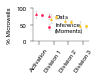

In [15]:
# plot copied from plot comment (fig_dots_w_mult_bars)
val_obj = np.array([
        np.array([[e_act_data, e_act_data - np.percentile(e_act_data_samples, 2.5), np.percentile(e_act_data_samples, 97.5) - e_act_data], 
                  [np.percentile(e_act_model_samples, 50.0), np.percentile(e_act_model_samples, 50.0) - np.percentile(e_act_model_samples, 2.5), np.percentile(e_act_model_samples, 97.5) - np.percentile(e_act_model_samples, 50.0)]]),
        np.array([[e_div1_data, e_div1_data - np.percentile(e_div1_data_samples, 2.5), np.percentile(e_div1_data_samples, 97.5) - e_div1_data], 
                  [np.percentile(e_div1_model_samples, 50.0), np.percentile(e_div1_model_samples, 50.0) - np.percentile(e_div1_model_samples, 2.5), np.percentile(e_div1_model_samples, 97.5) - np.percentile(e_div1_model_samples, 50.0)]]),
        np.array([[e_div2_data, e_div2_data - np.percentile(e_div2_data_samples, 2.5), np.percentile(e_div2_data_samples, 97.5) - e_div2_data], 
                  [np.percentile(e_div2_model_samples, 50.0), np.percentile(e_div2_model_samples, 50.0) - np.percentile(e_div2_model_samples, 2.5), np.percentile(e_div2_model_samples, 97.5) - np.percentile(e_div2_model_samples, 50.0)]]),
        np.array([[e_div3_data, e_div3_data - np.percentile(e_div3_data_samples, 2.5), np.percentile(e_div3_data_samples, 97.5) - e_div3_data], 
                  [np.percentile(e_div3_model_samples, 50.0), np.percentile(e_div3_model_samples, 50.0) - np.percentile(e_div3_model_samples, 2.5), np.percentile(e_div3_model_samples, 97.5) - np.percentile(e_div3_model_samples, 50.0)]])
        ], dtype=object)

attributes = {0: ('Activation', [cwact, cwact]),
              1: ('Division 1', [cwdiv, cwdiv]),
              2: ('Division 2', [cwdiv, cwdiv]),
              3: ('Division 3', [cwdiv, cwdiv])}

legend_attr = [('blue', 'x'), ('limegreen', 'y'), ('red', 'z')]

# initialise figure and axis settings
plt.rcParams.update({'figure.figsize': (1.0, 0.6)})

plt.figure()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# actual plotting
for val_ind in range(val_obj.shape[0]):
    color_list = attributes[val_ind][1]
    dots_per_categ = val_obj[val_ind].shape[0]

    if dots_per_categ == 1:
        x_pos = [val_ind + 1]
    elif dots_per_categ == 2:
        x_pos = [val_ind + 1 - 0.2, val_ind + 1 + 0.2]
    elif dots_per_categ == 3:
        x_pos = [val_ind + 1 - 0.2, val_ind + 1, val_ind + 1 + 0.2]

    for dot_ind in range(dots_per_categ):
        plt.errorbar(x_pos[dot_ind], val_obj[val_ind][dot_ind, 0],
                    yerr=val_obj[val_ind][dot_ind, 1:].reshape(2,1),
                    fmt='^' if dot_ind==0 else 'o', capsize=1, elinewidth=0.7, markeredgewidth=0.7,
                    markersize=2, markeredgecolor=color_list[dot_ind],
                    color=color_list[dot_ind], ecolor='lightgrey', zorder=1000,
                    label=['Data', 'Inference\n(Moments)'][dot_ind] if val_ind==0 else None)

# add x axis ticks
plt.xticks([val_ind + 1 for val_ind in range(val_obj.shape[0])],
                [attributes[val_ind][0] for val_ind in range(val_obj.shape[0])], rotation=55)

# add legend manually
# plt.legend(handles=[mpatches.Patch(color=leg[0], label=leg[1]) for leg in legend_attr])
plt.legend(frameon=False, loc='upper right')

plt.ylim(0, 100) # ylim(35, 90)
plt.ylabel('% Microwells')
plt.savefig('paper_figures/event_analysis_full_par2_d_6_8_l_18.pdf', bbox_inches='tight')

##### simulation-based inference of more waiting times (act, div1, div2, ...)

data waiting times

In [3]:
data = pickle.load(open('waiting_times_files/count_data_cd44_manual_counting_18_01_14_filtered_sigma022.pickle', 'rb'))
print(data.data_counts.shape)

data.events_find_all()

(44, 2, 28)


(-2.7, 60.0)

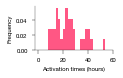

In [24]:
events = data.event_all_first_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Activation times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwact,
                density=True,
                alpha=0.75,
                histtype='stepfilled', # step, stepfilled
                linewidth=2.0)

plt.xlim(None, 60)
# plt.legend()
# plt.savefig('paper_figures/data_waiting_time_event_activation.pdf', bbox_inches='tight')

In [14]:
print(max(hist_tau))
print(events[30])

53.999999
(True, 54.0)


(-2.7, 60.0)

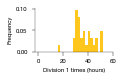

In [6]:
events = data.event_all_first_cell_count_increase

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Division 1 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwdiv,
                density=True,
                histtype='stepfilled', # step, stepfilled
                linewidth=2.0)

plt.xlim(None, 60)
# plt.legend()
# plt.savefig('paper_figures/data_waiting_time_event_division1.pdf', bbox_inches='tight')

(-2.7, 60.0)

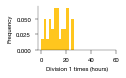

In [5]:
events = data.event_all_first_cell_count_increase_after_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Division 1 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwdiv,
                density=True,
                histtype='stepfilled', # step, stepfilled
                linewidth=2.0)

plt.xlim(None, 60)
# plt.legend()
# plt.savefig('paper_figures/data_waiting_time_event_division1.pdf', bbox_inches='tight')

(-2.7, 60.0)

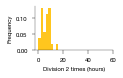

In [7]:
events = data.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Division 2 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwdiv,
                density=True,
                histtype='stepfilled', # step, stepfilled
                linewidth=2.0)

plt.xlim(None, 60)
# plt.legend()
# plt.savefig('paper_figures/data_waiting_time_event_division2.pdf', bbox_inches='tight')

(-2.7, 60.0)

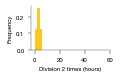

In [8]:
events = data.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Division 2 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwdiv,
                density=True,
                histtype='stepfilled', # step, stepfilled
                linewidth=2.0)

plt.xlim(None, 60)
# plt.legend()
# plt.savefig('paper_figures/data_waiting_time_event_division2.pdf', bbox_inches='tight')

inferred waiting times over all models (sigma022, mean/var/cov data)

In [2]:
data = pickle.load(open('waiting_times_files/count_data_cd44_manual_counting_18_01_14_filtered_sigma022.pickle', 'rb'))
print(data.data_counts.shape)

data.events_find_all()

(44, 2, 28)


In [3]:
res1 = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))
res2 = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))
res3 = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))
res = res1 + res2 + res3
print(len(res1), len(res2), len(res3), len(res))

# get net_names
net_names = [est.net.net_name for est in res]

# set model prior to give classes same weight
mprior = np.array([0.25] + [0.25/99]*99 + [0.25/288]*288 + [0.25/588]*588)
print(sum(mprior))
print(len(mprior))

100 288 588 976
1.000000000000017
976


In [4]:
### ADAPTED FROM hist_cell_counts_samples IN settings_load.py script
def simulate_inference(res, sample_n, mprior):
    model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)

    # set simulation results list
    res_list = list()

    # for checking set a counter
    model_type_counts = np.zeros((4,))

    for i in range(sample_n):
        if i%5000==0: print(i)
        # get random model according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = res[model_rand]

        # decide whether phase type or markov/erlang model
        # par 3 model
        if 'par3_' in est.net.net_name:
            model_type_counts[3] += 1
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            d1, d2, d3, l = theta
            theta_values = {'d1': d1, 'd2': d2,
                                'd3': d3, 'l1': l}

            # sim settings for par3 model
            time_values = est.data.data_time_values
            initial_values = {'M_t': 1, 'A_t': 0}
            variables = {'M_t': ('M_t', ), 'A_t': ('A_t', )}

            sim = me.Simulation(est.net)
            res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

        # par 2 model
        elif 'par2_' in est.net.net_name:
            model_type_counts[2] += 1

            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            d1, d2, l1 = theta
            theta_values = {'d1': d1, 'd2': d2, 'l1': l1}

            # sim settings for par2 model
            time_values = est.data.data_time_values
            initial_values = {'M_t': 1, 'A_t': 0}
            variables = {'M_t': ('M_t', ), 'A_t': ('A_t', )}

            sim = me.Simulation(est.net)
            res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

        # par1+i model (identified by d_ni symbolic rate)
        elif 'd_ni' in est.net.net_rates_identifier.values():
            model_type_counts[1] += 1

            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            dna, dni, l = theta
            theta_values = {'d_na': dna, 'd_ni': dni, 'la_a': l}

            # sim settings for par3 model
            time_values = est.data.data_time_values
            initial_values = {'N_t': 1, 'I_t': 0, 'A_t': 0}
            variables = {'M_t': ('N_t', 'I_t'), 'A_t': ('A_t', )}

            # different memopy versions
            # (sim = me.Simulation(est.net)) usually works
            dna_steps = est.net.net_modules[0]['module_steps']
            dni_steps = est.net.net_modules[1]['module_steps']
            l_steps = est.net.net_modules[2]['module_steps']

            t = [
            {'start': 'N_t', 'end': 'A_t', 'rate_symbol': 'd_na', 'type': 'S -> E', 'reaction_steps': dna_steps},
            {'start': 'N_t', 'end': 'I_t', 'rate_symbol': 'd_ni', 'type': 'S -> E', 'reaction_steps': dni_steps},
            {'start': 'A_t', 'end': 'A_t', 'rate_symbol': 'la_a', 'type': 'S -> S + S', 'reaction_steps': l_steps}
            ]

            net = me.Network(est.net.net_name)
            net.structure(t)

            sim = me.Simulation(net)
            res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

        # markov/erlang model
        else:
            model_type_counts[0] += 1
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            a1, l = theta
            theta_values = {'d_ma': a1, 'la_a': l}

            # sim settings for par3 model
            time_values = est.data.data_time_values
            initial_values = {'M_t': 1, 'A_t': 0}
            variables = {'M_t': ('M_t', ), 'A_t': ('A_t', )}

            # different memopy versions
            # (sim = me.Simulation(est.net)) usually works
            d_steps = est.net.net_modules[0]['module_steps']
            l_steps = est.net.net_modules[1]['module_steps']

            t = [
            {'start': 'M_t', 'end': 'A_t', 'rate_symbol': 'd_ma', 'type': 'S -> E', 'reaction_steps': d_steps},
            {'start': 'A_t', 'end': 'A_t', 'rate_symbol': 'la_a', 'type': 'S -> S + S', 'reaction_steps': l_steps}
            ]

            net = me.Network(est.net.net_name)
            net.structure(t)

            sim = me.Simulation(net)
            res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

    sims = np.array(res_list)
    print(model_type_counts)
    return sims

In [5]:
# simulate over all models in res with function below
sample_n = 100000

sim_res = simulate_inference(res, sample_n, mprior)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
[    0.     0. 55431. 44569.]


In [6]:
# convert the simulation results to a data object
# (with pseudo bootrap because we dont need summary stats)
time_values = res[0].data.data_time_values
data_sim = me.Data('data_sim_inference')
data_sim.load(['A_t', 'M_t'], time_values, sim_res, bootstrap_samples=3)

# trigger event analysis
data_sim.events_find_all()

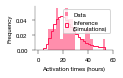

In [7]:
# real data
events = data.event_all_first_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

# simulation data
sim_events = data_sim.event_all_first_cell_type_conversion

sim_hist_bins = np.linspace(0, 54, num=28, endpoint=True)
sim_hist_tau = [tau - 1e-06 for (event_bool, tau) in sim_events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Activation times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwact,
                density=True,
                alpha=0.5,
                histtype='stepfilled', # step, stepfilled
                linewidth=1.0,
                label='Data')

plt.hist(sim_hist_tau,
                bins=sim_hist_bins,
                color=cwact,
                density=True,
                histtype='step', # step, stepfilled
                linewidth=1.0,
                label='Inference\n(Simulations)')
plt.legend()
plt.xlim(None, 60)
plt.savefig('paper_figures/waiting_times_act_sigma022_sims.pdf', bbox_inches='tight') # _long200 # pdf, png

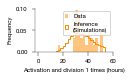

In [8]:
# real data
events = data.event_all_first_cell_count_increase

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

# simulation data
sim_events = data_sim.event_all_first_cell_count_increase

sim_hist_bins = np.linspace(0, 54, num=28, endpoint=True)
sim_hist_tau = [tau - 1e-06 for (event_bool, tau) in sim_events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Activation and division 1 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color='darkorange',
                density=True,
                alpha=0.5,
                histtype='stepfilled', # step, stepfilled
                linewidth=1.0,
                label='Data')

plt.hist(sim_hist_tau,
                bins=sim_hist_bins,
                color='darkorange',
                density=True,
                histtype='step', # step, stepfilled
                linewidth=1.0,
                label='Inference\n(Simulations)')
plt.legend()
plt.xlim(None, 60)
plt.savefig('paper_figures/waiting_times_div1act_sigma022_sims.pdf', bbox_inches='tight') # _long200 # pdf, png

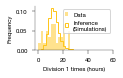

In [9]:
# real data
events = data.event_all_first_cell_count_increase_after_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

# simulation data
sim_events = data_sim.event_all_first_cell_count_increase_after_cell_type_conversion

sim_hist_bins = np.linspace(0, 54, num=28, endpoint=True)
sim_hist_tau = [tau - 1e-06 for (event_bool, tau) in sim_events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Division 1 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwdiv,
                density=True,
                alpha=0.5,
                histtype='stepfilled', # step, stepfilled
                linewidth=1.0,
                label='Data')

plt.hist(sim_hist_tau,
                bins=sim_hist_bins,
                color=cwdiv,
                density=True,
                histtype='step', # step, stepfilled
                linewidth=1.0,
                label='Inference\n(Simulations)')
plt.legend()
plt.xlim(None, 60)
plt.savefig('paper_figures/waiting_times_div1_sigma022_sims.pdf', bbox_inches='tight') # _long200 # pdf, png

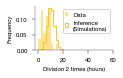

In [10]:
# real data
events = data.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

# simulation data
sim_events = data_sim.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion

sim_hist_bins = np.linspace(0, 54, num=28, endpoint=True)
sim_hist_tau = [tau - 1e-06 for (event_bool, tau) in sim_events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Division 2 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwdiv,
                density=True,
                alpha=0.5,
                histtype='stepfilled', # step, stepfilled
                linewidth=1.0,
                label='Data')

plt.hist(sim_hist_tau,
                bins=sim_hist_bins,
                color=cwdiv,
                density=True,
                histtype='step', # step, stepfilled
                linewidth=1.0,
                label='Inference\n(Simulations)')
plt.legend()
plt.xlim(None, 60)
plt.savefig('paper_figures/waiting_times_div2_sigma022_sims.pdf', bbox_inches='tight') # _long200 # pdf, png

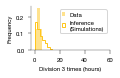

In [11]:
# real data
events = data.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion

hist_bins = np.linspace(0, 54, num=28, endpoint=True)
hist_tau = [tau - 1e-06 for (event_bool, tau) in events if event_bool]

# simulation data
sim_events = data_sim.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion

sim_hist_bins = np.linspace(0, 54, num=28, endpoint=True)
sim_hist_tau = [tau - 1e-06 for (event_bool, tau) in sim_events if event_bool]

plt.figure(figsize=(1.4, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Division 3 times (hours)')
plt.ylabel('Frequency')
plt.hist(hist_tau,
                bins=hist_bins,
                color=cwdiv,
                density=True,
                alpha=0.5,
                histtype='stepfilled', # step, stepfilled
                linewidth=1.0,
                label='Data')

plt.hist(sim_hist_tau,
                bins=sim_hist_bins,
                color=cwdiv,
                density=True,
                histtype='step', # step, stepfilled
                linewidth=1.0,
                label='Inference\n(Simulations)')
plt.legend()
plt.xlim(None, 60)
plt.savefig('paper_figures/waiting_times_div3_sigma022_sims.pdf', bbox_inches='tight') # _long200 # pdf, png

##### scheme for event types

18.0 32.0 14.0 12.0 4.0


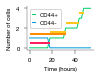

In [52]:
well_ind = 17
e_act = data.event_all_first_cell_type_conversion[well_ind][1]
e_actdiv = data.event_all_first_cell_count_increase[well_ind][1]
e_div1 = data.event_all_first_cell_count_increase_after_cell_type_conversion[well_ind][1]
e_div2 = data.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion[well_ind][1]
e_div3 = data.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion[well_ind][1]
print(e_act, e_actdiv, e_div1, e_div2, e_div3)

plt.figure(figsize=(1.2, 0.8))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('Time (hours)')
plt.ylabel('Number of cells')

plt.plot(data.data_time_values, data.data_counts[well_ind, 0, :], label='CD44+', lw=1, c=cactiv)
plt.plot(data.data_time_values, data.data_counts[well_ind, 1, :], label='CD44-', lw=1, c=cnaive)

ax.hlines(y=0.5, xmin=0, xmax=e_act, linewidth=2, color=cwact, zorder=100)
ax.hlines(y=1.35, xmin=0, xmax=e_actdiv, linewidth=2, color='darkorange', zorder=100)
ax.hlines(y=1.65, xmin=e_act, xmax=e_act+e_div1, linewidth=2, color=cwdiv, zorder=100)
ax.hlines(y=2.5, xmin=e_act+e_div1, xmax=e_act+e_div1+e_div2, linewidth=2, color=cwdiv, zorder=100)
ax.hlines(y=3.5, xmin=e_act+e_div1+e_div2, xmax=e_act+e_div1+e_div2+e_div3, linewidth=2, color=cwdiv, zorder=100)

# plt.xlim(None, 60)
plt.legend()
plt.savefig(f'paper_figures/data_well_{well_ind+1}_index{well_ind}.pdf', bbox_inches='tight')